# D2Q9

**With fewer than 100 lines of code, you can simulate your own von Kármán vortex street!**

Main code reference: https://youtu.be/JFWqCQHg-Hs. However, I believe the execution order in his main loop is incorrect.  

Main theory reference: [Lattice Boltzmann and Gas Kinetic Flux Solvers](https://doi.org/10.1142/11949).  

![alt text](figs/d2q9.svg)  

### Lattice Boltzmann Equation (LBE):

Consider the Boltzmann Equation:  

$$
\partial_{t}f + \vec{\xi}\cdot \nabla f = \Omega[f,f]
$$  

Integrate the following total differential using the **trapezoidal rule** (or equivalently, interpret it as the improved Euler method for solving ordinary differential equations):  

$$
\frac{\mathrm{d}}{\mathrm{d} \Delta t}f(\vec x + \vec{\xi}\Delta t, \vec{\xi}, t + \Delta t) = \partial_{t}f + \vec{\xi}\cdot \nabla f = \Omega[f,f]
$$  

This yields:  

$$
f(\vec x + \vec{\xi} \Delta t, \vec{\xi}, t + \Delta t) - f(\vec x, \vec{\xi}, t) = \frac{\Delta t}{2}\left[ \Omega(\vec x + \vec{\xi} \Delta t, \vec{\xi}, t + \Delta t) + \Omega(\vec x, \vec{\xi}, t) \right]
$$  

This is an implicit method—right?  

Move the terms involving \(\Delta t\) on the right-hand side to the left and combine them with the terms involving \(\Delta t\). Define:  

$$
\bar f = f - \frac{\Delta t}{2}\Omega[f,f] = f - \frac{\Delta t}{2\tau}(f^{\text{eq}} - f) = \frac{(2\tau + \Delta t)f - \Delta t\,f^{\text{eq}}}{2\tau}
$$  

After rearrangement, we obtain:  

$$
\bar f(\vec x + \vec{\xi}\Delta t, \vec{\xi}, t + \Delta t) - \bar f(\vec x, \vec{\xi}, t) = \frac{f^{\text{eq}}(\vec x, \vec{\xi}, t) - \bar f(\vec x, \vec{\xi}, t) }{\tau'},
$$

where:  
- $\tau' = \frac{\tau}{\Delta t} + \frac{1}{2}$ is a constant dimensionless number (for an isothermal case with a constant kinematic viscosity model);  
- $f^{\text{eq}}$ is the equilibrium distribution that $f$ relaxes to.  

By selecting an appropriate time step $\Delta t$ and a finite set of discrete velocity points $\{\vec{\xi}_\alpha\}$, we can construct a computational mesh with the following property: for any vertex $\vec{x}_i$ in the mesh, all points $\vec{x}_i + \vec{\xi}_{\alpha}\Delta t$ coincide with other mesh vertices. This property enables us to predict the evolution of the distribution functions at the mesh vertices and discrete velocity points using only information from the previous time step.  

### D2Q9 Scheme

Now the iteration begins. We use the **D2Q9 model**, which is a 2D structured grid with 9 velocity directions.

![alt text](figs/d2q9.svg)

The discrete velocities are denoted as $\tilde{\xi}$, giving:
$$
\begin{aligned}
\vec{\xi}_{0}/\tilde{\xi} &= (0, 0) := (I_0, J_0) &\\
\vec{\xi}_{1}/\tilde{\xi} &= (0, 1) := (I_1, J_1) & \vec{\xi}_{5}/\tilde{\xi} &= (1, 1) := (I_5, J_5) \\
\vec{\xi}_{2}/\tilde{\xi} &= (1, 0) := (I_2, J_2) & \vec{\xi}_{6}/\tilde{\xi} &= (-1, 1) := (I_6, J_6) \\
\vec{\xi}_{3}/\tilde{\xi} &= (0, -1) := (I_3, J_3) & \vec{\xi}_{7}/\tilde{\xi} &= (-1, -1) := (I_7, J_7) \\
\vec{\xi}_{4}/\tilde{\xi} &= (-1, 0) := (I_4, J_4) & \vec{\xi}_{8}/\tilde{\xi} &= (1, -1) := (I_8, J_8) \\
\end{aligned}
$$
where $\tilde{\xi} \Delta t = \Delta x$.

Define $f^{n}_{ij\alpha} = f(\vec{x}_{ij}, \vec{\xi}_\alpha, t^n)$. The Lattice Boltzmann Equation (LBE) then becomes:
$$
\bar f^{n+1}_{i + I_\alpha, j + J_\alpha, \alpha} = \bar f^{n}_{ij\alpha} + \frac{(f^{\text{eq}})^{n}_{ij\alpha} - \bar f^{n}_{ij\alpha}}{\tau'}
$$

### Discrete Distribution Functions and Quadrature

The key question now is how to determine $f^{\text{eq}}_{ij\alpha}$, which depends on the macroscopic variables $\rho$ and $\vec{u}$. If we had the full distribution function over momentum space, we could compute these variables via integration:

$$
\begin{gathered}
  \int {\rm d} \vec{\xi}~ f = \rho \\
  \int {\rm d} \vec{\xi}~ \vec{\xi} f = \rho \vec{u} \\
  f^{\text{eq}} = \frac{\rho}{(2\pi m k_{\rm B}T)^{D/2}}\exp\left[ -\frac{m(\vec{\xi}- \vec{u})^{2}}{2k_{\rm B}T}\right ]
\end{gathered}
$$

However, with only a finite set of discrete velocities, we approximate these integrals using quadrature. Since momentum space $\mathbb{R}^D$ is infinite, we require an appropriate weight function:

$$
\omega(\vec{\xi}) = \frac{1}{(2\pi m k_{\rm B}T)^{D/2}}\exp\left[ -\frac{m\vec{\xi}^{2}}{2k_{\rm B}T}\right].
$$

For a function $g(\vec{\xi})$, the quadrature formula becomes:
$$
\int {\rm d}\vec{\xi} \omega(\vec{\xi}) g(\vec{\xi}) \approx \sum_{i}^{N} \omega_i g(\vec{\xi}_i).
$$

Applied to the distribution function:
$$
\begin{aligned}
	\int {\rm d} \vec{\xi}~ f(\vec{\xi})q(\vec{\xi}) &= \int {\rm d} \vec{\xi}~ \omega(\vec{\xi}) \frac{f(\vec{\xi})}{\omega(\vec{\xi})}q(\vec{\xi}) \approx \sum_{\alpha = 0}^{N_\alpha - 1}f_{\alpha} q(\vec{\xi}_{\alpha}),
\end{aligned}
$$
where $q$ is a polynomial and $f_{\alpha} = \omega_{\alpha}\frac{f(\vec{\xi}_\alpha)}{\omega(\vec{\xi}_\alpha)}$. Here, $f_{\alpha}$ acts as a linear functional of $f$, making this a linear dimensionality reduction from $f(\vec{\xi})$ to $f_{\alpha}$.

From the discrete distribution function, we now compute macroscopic variables:
$$
\begin{aligned}
	\rho &= \sum_{\alpha = 0}^{N_\alpha - 1} f_{\alpha}, \\
	\rho \vec{u} &= \sum_{\alpha = 0}^{N_\alpha - 1} f_{\alpha} \vec{\xi}_{\alpha}.
\end{aligned}
$$

At equilibrium, the discrete distribution becomes:
$$
\begin{aligned}
f^{\text{eq}}_{\alpha} 
  &= \omega_{\alpha} \frac{f^{\text{eq}}(\vec{\xi_\alpha})}{\omega(\vec{\xi_\alpha})} = \rho \omega_{\alpha} \exp\left[ -\frac{m(\vec{u}^2 - 2 \vec{u} \cdot \vec{\xi})}{2k_{\rm B}T}\right ] \\
  &= \rho \omega_{\alpha} \left( 1 + \frac{\vec{\xi}\cdot\vec{u}}{k_{\rm B}T/m} + \frac{(\vec{\xi}\cdot\vec{u})^2}{2(k_{\rm B}T/m)^2} - \frac{\vec{u}\cdot\vec{u}}{2k_{\rm B}T/m} \right).
\end{aligned}
$$

For $\vec{\xi}_\alpha$ with $\tilde{\xi} = \sqrt{3 k_{\rm B}T/m}$, the weights are:
$$
\omega_0 = \frac{4}{9}, \quad \omega_{1,2,3,4} = \frac{1}{9}, \quad \omega_{5,6,7,8} = \frac{1}{36},
$$
as shown earlier. The equilibrium distribution then simplifies to:
$$
f^{\text{eq}}_{\alpha} = \rho \omega_{\alpha} \left( 1 + \frac{3\vec{\xi}\cdot\vec{u}}{\tilde{\xi}^2} + \frac{9(\vec{\xi}\cdot\vec{u})^2}{2\tilde{\xi}^4} - \frac{3\vec{u}\cdot\vec{u}}{2 \tilde{\xi}^2} \right).
$$

Using $\tilde{\xi}$ as the velocity unit, this becomes numerically:
$$
f^{\text{eq}}_{\alpha} = \rho \omega_{\alpha} \left( 1 + 3\vec{\xi}\cdot\vec{u} + \frac{9}{2}(\vec{\xi}\cdot\vec{u})^2 - \frac{3}{2}\vec{u}\cdot\vec{u} \right).
$$

Thus, we express the discrete equilibrium distribution entirely in terms of macroscopic variables.

### Algorithm Summary

![Cycle_overview.png](./figs/Cycle_overview.png)

The Lattice Boltzmann Method (LBM) implementation proceeds as follows:

1. **Compute equilibrium distribution** $(f^{\text{eq}})^{n}_{ij\alpha}$ from $\bar f^{n}_{ij\alpha}$:
   $$
   \begin{gathered}
       \rho = \sum_{\alpha=0}^{N_\alpha - 1} f_{\alpha}, \\
       \rho \vec{u} = \sum_{\alpha=0}^{N_\alpha - 1} \vec{\xi}_{\alpha}f_{\alpha}, \\
       f^{\text{eq}}_{\alpha} = \rho \omega_{\alpha} \left( 1 + 3\vec{\xi}\cdot\vec{u} + \frac{9}{2}(\vec{\xi}\cdot\vec{u})^2 - \frac{3}{2}\vec{u}\cdot\vec{u} \right),
   \end{gathered}
   $$
   where subscripts $ij$ are omitted for clarity.

2. **Collision step**:
   Compute the post-collision distribution:
   $$
   \bar f^{*}_{ij\alpha} = \bar f^{n}_{ij\alpha} + \frac{(f^{\text{eq}})^{n}_{ij\alpha} - \bar f^{n}_{ij\alpha}}{\tau'}.
   $$

3. **Streaming step**:
   Propagate the distribution to neighboring nodes:
   $$
   \bar f^{n+1}_{ij\alpha} = (\bar f^*)^{n}_{i-I_\alpha,j - J_\alpha,\alpha}.
   $$

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
# using svg backend
%config InlineBackend.figure_format = 'svg'
from IPython.display import clear_output

In [2]:
# isothermal and constant kinematic viscosity
Nx = 400
Ny = 100
tau = .53 # numerical relaxation time 

In [3]:
Nv = 9  # Number of velocities in D2Q9 model
veloI = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])  # x-components of velocities
veloJ = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])  # y-components of velocities
weights = np.array([16, 4, 4, 4, 4, 1, 1, 1, 1]) / 36  # weights for D2Q9 model

# # plot to check
# for i in range(Nv):
#     plt.scatter(veloI[i], veloJ[i])
#     plt.text(veloI[i], veloJ[i], f'{i},{weights[i]:.2f}', fontsize=12, ha='center')
# plt.show()


In [4]:
def setfeq(rho, ux, uy):
    cdot = veloI * ux + veloJ * uy
    return rho * weights * (
        1 + 3 * cdot + 9/2 * cdot**2 - 3/2 * (ux**2 + uy**2)
    )

movingfeq = setfeq(1, 0.1, 0)
staticfeq = setfeq(1, 0, 0)

In [5]:
# geometry
radius = 13
cylinder = np.full((Nx, Ny), False)
center = (Nx // 4, Ny // 2)
for i in range(Nx):
    for j in range(Ny):
        if (i - center[0])**2 + (j - center[1])**2 < radius**2:
            cylinder[i, j] = True

In [6]:
# initial conditions
boltzmannf = np.ones((Nx, Ny, Nv)) + 0.01 * np.random.rand(Nx, Ny, Nv)  
boltzmannf[:, :, 2] = 2.3  # initial velocity in x-direction
# rho = 10.3
# ux = 1.28
# uy = 0
# boltzmannf = np.ones((Nx, Ny, Nv))
# boltzmannf[:, :] = movingfeq
# boltzmannf[cylinder] = staticfeq

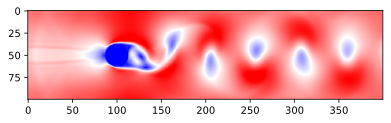

100%|██████████| 10000/10000 [03:23<00:00, 49.03it/s]


In [7]:
import os
import shutil
shutil.rmtree('simufigs')
os.mkdir('simufigs')

from tqdm import tqdm

Nt = 10000
skip = 50
savefig = True
# using `ffmpeg -i frame_%04d.png -r 20 output.mp4` to generate vedio

pbar = tqdm(total=Nt)
figlabel = 0
for it in range(Nt):
    rho = np.sum(boltzmannf, axis=2)  # density
    ux = np.sum(boltzmannf * veloI, axis=2) / rho  # x-velocity
    uy = np.sum(boltzmannf * veloJ, axis=2) / rho  # y-velocity

    # Compute equilibrium distribution function
    boltzmannfeq = np.zeros_like(boltzmannf)
    for i in range(Nv):
        cdot = veloI[i] * ux + veloJ[i] * uy
        boltzmannfeq[:, :, i] = rho * weights[i] * (1 + 3 * cdot + 9/2 * cdot**2 - 3/2 * (ux**2 + uy**2))

    # collection step
    boltzmannf = boltzmannf + (boltzmannfeq - boltzmannf) / tau

    # Streaming step
    for i in range(Nv):
        boltzmannf[:, :, i] = np.roll(boltzmannf[:, :, i],
                                      (veloI[i], veloJ[i]),
                                      axis=(0, 1))
        
    # # Bouncing Back boundary condition(no-slip wall)
    boltzmannf[cylinder, :] = boltzmannf[cylinder, :][:,[0, 3, 4, 1, 2, 7, 8, 5, 6]]
    # # Absorption boundary condition
    # boltzmannf[0, :, [2, 5, 6]] = boltzmannf[1, :, [2, 5, 6]]
    # boltzmannf[-1, :, [4, 7, 8]] = boltzmannf[-2, :, [4, 7, 8]]
    boltzmannf[0, :, :] = boltzmannf[1, :, :]
    boltzmannf[-1, :, :] = boltzmannf[-2, :, :]
    # # inlet
    # boltzmannf[0, :] = movingfeq

    # Visualization
    ux[cylinder] = 0
    uy[cylinder] = 0
    if it % skip == 0:
        clear_output(wait=True)
        plt.imshow(np.sqrt(ux**2 + uy**2).T, cmap='bwr',
                   vmin = 0, vmax = 0.18)

        # plt.imshow(rho.T, cmap='bwr',vmin = 0, vmax = 0.18)

        # plot the vorticity
        # plt.imshow((np.gradient(uy, axis=0) - np.gradient(ux, axis=1)).T,
        #            cmap='bwr', vmin = -0.08, vmax = 0.08)

        # plt.colorbar(orientation='horizontal') 
        # plt.title(f'Timestep {it}')
        if savefig:
            plt.savefig(f'simufigs/frame_{figlabel:04d}.png', dpi = 300)
            figlabel += 1
            # you can using ffmpeg to create a video from the saved frames
        plt.pause(.02)
        pbar.update(skip)
pbar.close()

Well, from the code above, you might find it difficult to determine what physical parameters govern this case. This reflects the multi-scale nature of the lattice Boltzmann method.

In this simulation:
- $\Delta x = \tilde{\xi}\Delta t$, where $\tilde{\xi} = \sqrt{\frac{3k_{\rm B}T}{m}}$
- $\tau' = 0.53$ leads to:  
  $$
  \left(\tau' - \frac{1}{2}\right)\Delta t = \tau = \frac{\nu m}{k_{\rm B} T}\Rightarrow \nu = \left( \tau' - \frac{1}{2} \right) \Delta t \frac{k_{\rm B} T}{m}
  $$

By choosing an appropriate $\Delta t$, we can determine the physical parameters for this case.

Let's choose appropriate parameters. First, we rewrite the expression for $\tilde{\xi}$:
$$
\tilde{\xi} = \sqrt{\frac{3k_{\rm B}T}{m}} = \sqrt{\frac{3(k_{\rm B}N_{\rm A})T}{M}},
$$
where:
- $k_{\rm B}N_{\rm A}$ is the ideal gas constant,
- $M$ is the molar mass of the gas.

Given room temperature and air properties, we can calculate $\tilde{\xi}$.

In [8]:
import astropy.constants as const
import astropy.units as units

R = const.k_B * const.N_A
# R = const.R # is also okey. 
M = 29 * units.g/units.mol
T = (25 + 273.15)*units.K  # temperature in Kelvin
ref_vel = np.sqrt(3*R*T/M).si
ref_vel

<Quantity 506.40283436 m / s>

Let's choose $\Delta x = 0.01~{\rm m}$, making our computational domain $1~{\rm m} \times 4~{\rm m}$. This determines our time step $\Delta t$ through the relation:

$$
\Delta t = \frac{\Delta x}{\tilde{\xi}}.
$$

In [9]:
dx = 0.01 * units.m
dt = dx / ref_vel
dt

<Quantity 1.97471249e-05 s>

The total simulation time is:

In [10]:
dt * Nt

<Quantity 0.19747125 s>

Finally, the kinetic viscosity $\nu$ can be calculated.

In [11]:
nu = ((tau - .5) * dt * R * T / M).si
nu

<Quantity 0.05064028 m2 / s>